In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import rc
import scipy.io as sio
import os 
import itertools
import re
from matplotlib.patches import Polygon
import scipy.io as sio
import math
import csv
import random
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from scipy.fftpack import fftn, ifftn, fft, ifft
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import signal
import pickle
from sklearn.externals import joblib
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

font = {'family' : 'sans-serif',
        'style' : 'normal',
        'weight' : 'light',
        'size'   : 20}

rc('font', **font)

In [ ]:
DEBUG = False

In [ ]:
def load_data(file_path, file_name, user_id, g_phase_id, phase_id, movement_id):
    mat = sio.loadmat(file_path)
    mat_data = mat[file_name]['daq'][0, 0]
    t = pd.DataFrame(mat_data['t'][0,0], columns = ["timeStamp"])
    data = pd.DataFrame(mat_data['DAQ_DATA'][0, 0], columns = [
        'channel_1',
        'channel_2',
        'channel_3',
        'channel_4',
        'channel_5',
        'channel_6',
        'channel_7',
        'channel_8'
      ])
    #res = pd.concat([t, data], axis = 1, ignore_index = False, sort = False).set_index('TimeStamp')
    res = pd.concat([t, data], axis = 1, ignore_index = False, sort = False)
    res['userID'] = user_id
    res['gamePhase'] = g_phase_id
    res['testPhase'] = phase_id
    res['movementID'] = movement_id
    return res

In [ ]:
def generate_df():
    df = pd.DataFrame() # Main DataFrame
    rootdir = os.path.join(os.path.dirname(os.getcwd()) + "/Data_Sets/")
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            list_subdir = subdir.replace(rootdir,"").split("/")
            if (file.endswith(".mat") and (list_subdir[1] != "Game")):
                file_path = os.path.join(subdir, file)
                file_name = file.replace(".mat", "")
                try: 
                    user_id = [s for s in list_subdir if "user" in s][0].replace("user_","")
                    g_phase_id = [s for s in list_subdir if "game" in s][0] # Trainig Phase ID
                    list_fileName = ["".join(x) for _, x in itertools.groupby(file.split("_")[1].replace("Phase", ""), key=str.isdigit)]
                    phase_id = list_fileName[0].replace("Phase", "") 
                    movement_id = re.sub(r"(\w)([A-Z])", r"\1 \2", list_fileName[1])
                except: 
                    print (file_path)
                    print (subdir)
                    print("Error: Please check the Directory's hierarchy -> Corrupt")
                df = df.append(load_data(file_path, file_name, user_id, g_phase_id, phase_id, movement_id)) 
    return df

In [ ]:
df = generate_df()

In [ ]:
if DEBUG:
    df

In [ ]:
# Initiate Moving Window:
# for each user -> Phase 1 -> For each movement -> Window 
# sliding window of size 200 and with 87.5% overlap
# for each user -> Get moving window -> For each moving window compute features -> Put in

In [ ]:
def safe_ln(x):
    minval=1e-30
    return np.log(x.clip(minval))

In [ ]:
def sliding_windows(d, w, t):
    r = np.arange(len(d))
    s = r[::t]
    z = list(zip(s, s + w))
    f = '{0[0]}:{0[1]}'.format
    g = lambda t: d.iloc[t[0]:t[1]]
    return pd.concat(map(g, z), keys=map(f, z))

In [ ]:
def time_domain_descriptors(df):
    # Normalization Factor
    m_lambda = 0.1
    # Root squared zero order moment
    m_0 = np.sqrt((df ** 2).sum()) / m_lambda
    # Root squared second moment
    m_2 = np.sqrt(np.mean(np.diff(df, n = 1, axis = 0) ** 2, axis=0))
    m_2 = pd.DataFrame(m_2, index = m_0.index) / m_lambda
    # Root squared fourth order moment
    m_4 = np.sqrt(np.mean(np.diff(df, n = 2, axis = 0) ** 2, axis=0))
    m_4 = pd.DataFrame(m_4, index = m_0.index) / m_lambda
    # Reshape and Normalize
    m_x = pd.concat([m_0, m_2, m_4], axis=1)
    m_x.columns = ['m_0', 'm_2', 'm_4']
    m_x = m_x / (m_x['m_0'].median())
    # Coefficient of Variation
    m_cov = df.std() / df.mean()
    # Teager–Kaiser energy operator (df[1:-2] -> j / df[2:-1] -> j+1 / df[0:-3] -> j-1)
    m_tke = pd.DataFrame(df[1:-2].values*df[1:-2].values - df[0:-3].values*df[2:-1].values, columns = df.columns, index=df[0:-3].index).sum()
    
    # Signal Time-Domain Descriptors
    f_1 = safe_ln(m_x['m_0'])
    f_2 = safe_ln(m_x['m_0'] - m_x['m_2'])
    f_3 = safe_ln(m_x['m_0'] - m_x['m_4'])
    f_4 = safe_ln(m_x['m_0'] / ((np.sqrt(m_x['m_0'] - m_x['m_4'])*np.sqrt(m_x['m_0'] - m_x['m_4']))))
    f_5 = safe_ln(np.sqrt((m_x['m_0']*m_x['m_0'])/(m_x['m_0']*m_x['m_4'] + 1e-1)))
    f_6 = safe_ln(m_cov)
    f_7 = safe_ln(m_tke) 
    
    df_tdd = pd.concat([f_1, f_2, f_3, f_4, f_5, f_6, f_7], axis=1)
    df_tdd.columns = ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7']
    return df_tdd

In [ ]:
def temporal_spatial_features_per_window(df):
    # Build channel differences and expand dataframe
    df_tds = df.copy()
    for ii in df.columns:
        for jj in df.columns:
            if ii != jj:
                index = ii + '-' + jj
                df_tds[index] = df[ii] - df[jj]
    
    tdd_a = time_domain_descriptors(df_tds)
    df_ln = safe_ln(df_tds **2)
    tdd_b = time_domain_descriptors(df_ln)
    df_features = (tdd_a*tdd_b) / (np.sqrt((tdd_b**2).sum()) * np.sqrt((tdd_a**2).sum()))
    return df_features

In [ ]:
if DEBUG:
    df_tds = df[(df.userID == '20181112T183527') & (df.gamePhase == 'Pregame') & (df.testPhase == '1') & (df.movementID == 'Wrist Pronation')].iloc[:10, :].copy()
    df_tds.drop(labels=['userID', 'gamePhase', 'testPhase', 'movementID', 'timeStamp'], axis=1, inplace=True)
    temporal_spatial_features_per_window(df_tds)

In [ ]:
def temporal_spatial_features(df):
    # Extract relevant data
    df1 = df[(df.testPhase == '1') & (df.gamePhase == 'Pregame')].copy()
    df1.drop (labels = ['gamePhase', 'testPhase', 'timeStamp'], axis = 1, inplace = True)
    
    # Data Frame containing all Temporal Spatial Features for all users for all movements
    df_users_tsf = pd.DataFrame()
        
    # Loop over each user
    for user in np.unique (df1.userID):
        print("Handling User: " + user)
        # Data Frame containing all Temporal Spatial Features for a specific user for all movements
        df_user_tsf = pd.DataFrame()
        
        # Loop over each movement
        for movement in np.unique(df1.movementID):
            # Extract relevant data
            df_movement = df1[(df1.userID == user) & (df1.movementID == movement)].copy()
            df_movement.drop (labels = ['userID', 'movementID'], axis = 1, inplace = True)
            
            # Build sliding windows
            df_windows = sliding_windows(df_movement, 150, 50)
            
            # Data Frame containing all Temporal Spatial Features for all sliding windows for specific movement
            df_movement_tsf = pd.DataFrame()
            
            # Loop over each window
            for window_index in np.unique([index[:][0] for index in df_windows.index]):
                # Extract data of specific window
                df_window = df_windows.loc[window_index]
                # Extract Temporal Spatial Feature of specific window
                df_window_tsf = temporal_spatial_features_per_window(df_window)
                # Add sub_index for more clarity
                df_window_tsf['window'] = window_index
                df_window_tsf.set_index('window', append=True, inplace=True)
                # Append features of specific window to df_windows_tsf
                df_movement_tsf = df_movement_tsf.append(df_window_tsf)
                
            # Restructure df_windows_tsf for more clarity
            df_movement_tsf['movementID'] = movement
            df_movement_tsf.set_index('movementID', append=True, inplace=True)
            df_movement_tsf.index.names = ['subfeature', 'window', 'movementID']
            df_movement_tsf.columns.names = ['feature']
            df_movement_tsf = df_movement_tsf.pivot_table(
                        index=['movementID', 'window'], 
                        columns=['subfeature'], 
                        aggfunc=np.sum)
            
            # Append feature of specific movement to df_user_tsr
            df_user_tsf = df_user_tsf.append(df_movement_tsf)
        
        df_user_tsf['userID'] = user
        df_user_tsf.set_index('userID', append=True, inplace=True)
        df_users_tsf = df_users_tsf.append(df_user_tsf)
    df_users_tsf = df_users_tsf.reorder_levels(['userID', 'movementID', 'window'])
    print("Done")
    return df_users_tsf

In [ ]:
features_df = temporal_spatial_features(df)
features_df.columns = features_df.columns.map('_'.join)
features_df = features_df.reset_index(level=['userID', 'movementID', 'window'])
features_df.to_csv("mohamed_extracted_features_phase_1.csv", index=False)

In [3]:
df = pd.read_csv("mohamed_extracted_features_phase_1.csv")

In [4]:
# Change appropriate columns to either floats or ints
df[df.columns.difference(['movementID','userID','window'])] = df[df.columns.difference(['movementID','userID','window'])].apply(pd.to_numeric)

In [5]:
df

userID        movementID       window  f_1_channel_1  \
0      20181018T150232_Kevin       Hand Closed        0:150       0.002914   
1      20181018T150232_Kevin       Hand Closed  10000:10150       0.013010   
2      20181018T150232_Kevin       Hand Closed    1000:1150       0.003050   
3      20181018T150232_Kevin       Hand Closed  10050:10200       0.014928   
4      20181018T150232_Kevin       Hand Closed      100:250       0.005060   
5      20181018T150232_Kevin       Hand Closed  10100:10250       0.012241   
6      20181018T150232_Kevin       Hand Closed  10150:10300       0.012800   
7      20181018T150232_Kevin       Hand Closed  10200:10350       0.013576   
8      20181018T150232_Kevin       Hand Closed  10250:10400       0.010082   
9      20181018T150232_Kevin       Hand Closed  10300:10450       0.011101   
10     20181018T150232_Kevin       Hand Closed  10350:10500       0.005010   
11     20181018T150232_Kevin       Hand Closed  10400:10550       0.002053   
12     20181018T150232_Kevin       Hand Closed  10450:10600       0.000036   
13     20181018T150232_Kevin       Hand Closed  10500:10650       0.001199   
14     20181018T150232_Kevin       Hand Closed    1050:1200       0.005387   
15     20181018T150232_Kevin       Hand Closed  10550:10700       0.001142   
16     20181018T150232_Kevin       Hand Closed  10600:10750       0.001639   
17     20181018T150232_Kevin       Hand Closed  10650:10800       0.000394   
18     20181018T150232_Kevin       Hand Closed  10700:10850       0.005138   
19     20181018T150232_Kevin       Hand Closed  10750:10900       0.005618   
20     20181018T150232_Kevin       Hand Closed  10800:10950       0.005492   
21     20181018T150232_Kevin       Hand Closed  10850:11000       0.006322   
22     20181018T150232_Kevin       Hand Closed  10900:11050       0.004175   
23     20181018T150232_Kevin       Hand Closed  10950:11100       0.003283   
24     20181018T150232_Kevin       Hand Closed  11000:11150       0.005975   
25     20181018T150232_Kevin       Hand Closed    1100:1250       0.011031   
26     20181018T150232_Kevin       Hand Closed  11050:11200       0.002786   
27     20181018T150232_Kevin       Hand Closed  11100:11250       0.001780   
28     20181018T150232_Kevin       Hand Closed  11150:11300       0.000656   
29     20181018T150232_Kevin       Hand Closed  11200:11350       0.002741   
...                      ...               ...          ...            ...   
55369        20181126T165124  Wrist Supination    8600:8750      -0.005775   
55370        20181126T165124  Wrist Supination    8650:8800      -0.004694   
55371        20181126T165124  Wrist Supination    8700:8850      -0.008505   
55372        20181126T165124  Wrist Supination    8750:8900      -0.008987   
55373        20181126T165124  Wrist Supination    8800:8950      -0.007995   
55374        20181126T165124  Wrist Supination    8850:9000      -0.005193   
55375        20181126T165124  Wrist Supination    8900:9050      -0.004334   
55376        20181126T165124  Wrist Supination    8950:9100      -0.005291   
55377        20181126T165124  Wrist Supination    9000:9150      -0.003866   
55378        20181126T165124  Wrist Supination     900:1050      -0.019718   
55379        20181126T165124  Wrist Supination    9050:9200      -0.004799   
55380        20181126T165124  Wrist Supination    9100:9250      -0.005007   
55381        20181126T165124  Wrist Supination    9150:9300      -0.003988   
55382        20181126T165124  Wrist Supination    9200:9350      -0.003579   
55383        20181126T165124  Wrist Supination    9250:9400      -0.004615   
55384        20181126T165124  Wrist Supination    9300:9450      -0.006795   
55385        20181126T165124  Wrist Supination    9350:9500      -0.006148   
55386        20181126T165124  Wrist Supination    9400:9550      -0.008260   
55387        20181126T165124  Wrist Supination    9450:9600      -0.006863   
55388        20181126T165124  Wrist Supinati

## Training Setup

In [6]:
def split_train_test():
    user_ids = (np.unique(df.userID))
    random.Random(4).shuffle(user_ids)
    train_user_ids = []
    test_user_ids = []
    for user_index in range(0,int(math.ceil(len(user_ids)*0.75))):
        train_user_ids.append(user_ids[user_index])
    for user_index in range(int(math.ceil(len(user_ids)*0.75)),len(user_ids)):
        test_user_ids.append(user_ids[user_index])
    return train_user_ids,test_user_ids
train_user_ids,test_user_ids = split_train_test()

In [7]:
# TODO Change skf split based on this value
print(train_user_ids)

['20181126T133411', '20181126T165124', '20181107T184845', '20181113T144813', '20181106T142811', '20181126T144043', '20181119T181351', '20181108T173019', '20181023T152814_Brian', '20181106T195550', '20181106T172825', '20181018T150232_Kevin', '20181112T183527', '20181018T164607_Danyan', '20181018T170849_Varun']


In [8]:
def cross_validation_split(train_user_ids):
    train_slice = df.loc[df['userID'].isin(train_user_ids)]
    train_slice_kfold_y = train_slice['userID']
    
    skf = StratifiedKFold(n_splits=10)
    return skf
skf_train = cross_validation_split(train_user_ids)

In [9]:
# Contains correct train test split code for this purpose
def phase1_split_data_v2(train_user_ids,test_user_ids):
    phase1_df = df
    data = phase1_df.copy()
    train_slice = data.loc[data['userID'].isin(train_user_ids)]
    test_slice = data.loc[data['userID'].isin(test_user_ids)]
    train = train_slice.copy()
    test = test_slice.copy()
    y_train = train['movementID']
    y_test = test['movementID']
    train.drop(labels=['userID','movementID','window'], axis=1, inplace=True)
    test.drop(labels=['userID','movementID','window'], axis=1, inplace=True)
    return train, test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = phase1_split_data_v2(train_user_ids, test_user_ids)

## Utility Functions

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Classifiers

## Random Forest

In [10]:
def random_forest_all_users_v2():
    r_clf = RandomForestClassifier(n_estimators=200)
    parameter_grid = {'min_samples_split':[5,10],
                  'max_depth':[150,200]}
    clf = GridSearchCV(r_clf, parameter_grid, cv=skf_train)
    clf.fit(X_train, y_train)
    print("Best Parameters are: " + str(clf.best_params_))
    print("Cross Validation Score is: " + str(clf.best_score_))
    print("Prediction Score is: " + str(clf.score(X_test, y_test)))
    return clf.best_estimator_

model = random_forest_all_users_v2()

Best Parameters are: {'max_depth': 150, 'min_samples_split': 5}
Cross Validation Score is: 0.602664671381
Prediction Score is: 0.333476517755


In [11]:
def random_forest_all_users_v2():
    r_clf = RandomForestClassifier(n_estimators=300)
    parameter_grid = {'min_samples_split':[3,5],
                      'max_depth':[120,150]}
    clf = GridSearchCV(r_clf, parameter_grid, cv=skf_train)
    clf.fit(X_train, y_train)
    print("Best Parameters are: " + str(clf.best_params_))
    print("Cross Validation Score is: " + str(clf.best_score_))
    print("Prediction Score is: " + str(clf.score(X_test, y_test)))
    return clf.best_estimator_

model_1 = random_forest_all_users_v2()

Best Parameters are: {'max_depth': 120, 'min_samples_split': 3}
Cross Validation Score is: 0.60423354493
Prediction Score is: 0.35538373425


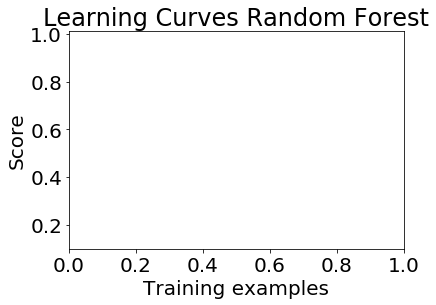

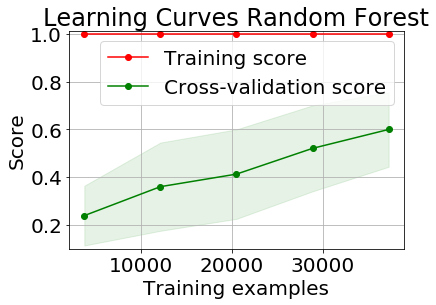

In [27]:
# Plot Results

title = "Learning Curves Random Forest"
plot_learning_curve(model_1, title, X_train, y_train, ylim=(0.1, 1.01), cv=skf_train)

plt.show()

In [19]:
joblib.dump(model_1, 'saved_model_python_3_cv_10_depth_120_min_split_3_train_15.pkl')

['saved_model_python_3_cv_10_depth_120_min_split_3_train_15.pkl']

In [20]:
model_1_reload = joblib.load('saved_model_python_3_cv_10_depth_120_min_split_3_train_15.pkl')

In [22]:
print("Prediction Score is: " + str(model_1_reload.score(X_test, y_test)))

Prediction Score is: 0.35538373425


In [12]:
def random_forest_all_users_v2():
    r_clf = RandomForestClassifier(n_estimators=400)
    parameter_grid = {'min_samples_split':[2,3],
                  'max_depth':[100,120]}
    clf = GridSearchCV(r_clf, parameter_grid, cv=skf_train)
    clf.fit(X_train, y_train)
    print("Best Parameters are: " + str(clf.best_params_))
    print("Cross Validation Score is: " + str(clf.best_score_))
    print("Prediction Score is: " + str(clf.score(X_test, y_test)))
    return clf.best_estimator_

model_2 = random_forest_all_users_v2()

Best Parameters are: {'max_depth': 120, 'min_samples_split': 2}
Cross Validation Score is: 0.602037121962
Prediction Score is: 0.3218069874


In [13]:
def random_forest_all_users_v2():
    r_clf = RandomForestClassifier(n_estimators=500)
    parameter_grid = {'min_samples_split':[2,3],
                  'max_depth':[70,90,110]}
    clf = GridSearchCV(r_clf, parameter_grid, cv=skf_train)
    clf.fit(X_train, y_train)
    print("Best Parameters are: " + str(clf.best_params_))
    print("Cross Validation Score is: " + str(clf.best_score_))
    print("Prediction Score is: " + str(clf.score(X_test, y_test)))
    return clf.best_estimator_

model_3 = random_forest_all_users_v2()

Best Parameters are: {'max_depth': 110, 'min_samples_split': 2}
Cross Validation Score is: 0.601168207381
Prediction Score is: 0.309994272623
